# Generate synthetic/simulated datasets for testing out package

In [187]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [188]:
# Autoreload
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2



import os, sys, h5py
import numpy as np
import pandas as pd

# plotting tools
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# random1000

In [ ]:
eu.utils.generate_random_data(num_seqs=1000, seq_len=66, out_dir="../_data/datasets/")

# Peter Koo's code
https://github.com/p-koo/learning_sequence_motifs/blob/master/code/0_Generate_synthetic_dataset.ipynb

In [189]:
!wget https://raw.githubusercontent.com/p-koo/learning_sequence_motifs/master/data/pfm_vertebrates.txt

--2022-12-15 10:33:57--  https://raw.githubusercontent.com/p-koo/learning_sequence_motifs/master/data/pfm_vertebrates.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135700 (133K) [text/plain]
Saving to: ‘pfm_vertebrates.txt.2’

pfm_vertebrates.txt 100%[===================>] 132.52K  --.-KB/s    in 0.02s   

2022-12-15 10:33:57 (8.19 MB/s) - ‘pfm_vertebrates.txt.2’ saved [135700/135700]



In [190]:
def get_jaspar_motifs(file_path):
    def get_motif(f):
        line = f.readline()
        name = line.strip().split()[1]
        pfm = []
        for i in range(4):
            line = f.readline()
            if len(line.split()[1]) > 1:
                pfm.append(np.asarray(np.hstack([line.split()[1][1:], line.split()[2:-1]]), dtype=float))
            else:
                pfm.append(np.asarray(line.split()[2:-1], dtype=float))
        pfm = np.vstack(pfm)
        sum_pfm = np.sum(pfm, axis=0)
        pwm = pfm/np.outer(np.ones(4), sum_pfm)
        line = f.readline()
        return name, pwm

    num_lines = sum(1 for line in open(file_path))
    num_motifs = int(num_lines/6)

    f = open(file_path)
    tf_names = []
    tf_motifs = []
    for i in range(num_motifs):
        name, pwm = get_motif(f)
        tf_names.append(name)
        tf_motifs.append(pwm)

    return tf_motifs, tf_names

# parse JASPAR motifs
file_path = os.path.join('pfm_vertebrates.txt')
motif_set, motif_names = get_jaspar_motifs(file_path)

# get a subset of core motifs 
core_names = ['Arid3a', 'CEBPB', 'FOSL1', 'Gabpa', 'MAFK', 'MAX', 
              'MEF2A', 'NFYB', 'SP1', 'SRF', 'STAT1', 'YY1']

strand_motifs = []
core_index = []
for name in core_names:
    strand_motifs.append(motif_set[motif_names.index(name)])
    core_index.append(motif_names.index(name))

# generate reverse compliments
core_motifs = []
for pwm in strand_motifs:
    core_motifs.append(pwm)
    reverse = pwm[:,::-1]
    core_motifs.append(reverse[::-1,:]) 

In [198]:
def seq_logo(pwm, height=30, nt_width=10, norm=0, alphabet='dna', colormap='standard'):

	def get_nt_height(pwm, height, norm):

		def entropy(p):
			s = 0
			for i in range(len(p)):
				if p[i] > 0:
					s -= p[i]*np.log2(p[i])
			return s

		num_nt, num_seq = pwm.shape
		heights = np.zeros((num_nt,num_seq));
		for i in range(num_seq):
			if norm == 1:
				total_height = height
			else:
				total_height = (np.log2(num_nt) - entropy(pwm[:, i]))*height;
			if alphabet == 'pu':
				heights[:,i] = np.floor(pwm[:,i]*np.minimum(total_height, height));
			else:
				heights[:,i] = np.floor(pwm[:,i]*np.minimum(total_height, height*2));

		return heights.astype(int)


	# get the alphabet images of each nucleotide
	package_directory = os.path.dirname(os.path.abspath(__file__))
	char_path = os.path.join(package_directory,'chars')
	chars = load_alphabet(char_path, alphabet, colormap)

	# get the heights of each nucleotide
	heights = get_nt_height(pwm, height, norm)

	# resize nucleotide images for each base of sequence and stack
	num_nt, num_seq = pwm.shape
	width = np.ceil(nt_width*num_seq).astype(int)

	if alphabet == 'pu':
		max_height = height
	else:
		max_height = height*2
	#total_height = np.sum(heights,axis=0) # np.minimum(np.sum(heights,axis=0), max_height)
	logo = np.ones((max_height, width, 3)).astype(int)*255;
	for i in range(num_seq):
		nt_height = np.sort(heights[:,i]);
		index = np.argsort(heights[:,i])
		remaining_height = np.sum(heights[:,i]);
		offset = max_height-remaining_height

		for j in range(num_nt):
			if nt_height[j] > 0:
				# resized dimensions of image
				nt_img = imresize(chars[index[j]], (nt_height[j], nt_width))

				# determine location of image
				height_range = range(remaining_height-nt_height[j], remaining_height)
				width_range = range(i*nt_width, i*nt_width+nt_width)

				# 'annoying' way to broadcast resized nucleotide image
				if height_range:
					for k in range(3):
						for m in range(len(width_range)):
							logo[height_range+offset, width_range[m],k] = nt_img[:,m,k];

				remaining_height -= nt_height[j]

	return logo.astype(np.uint8)
    
def plot_seq_logo(logo, nt_width=None, step_multiple=None):
	plt.imshow(logo, interpolation='none')
	if nt_width:
		num_nt = logo.shape[1]/nt_width
		if step_multiple:
			step_size = int(num_nt/(step_multiple+1))
			nt_range = range(step_size, step_size*step_multiple)
			plt.xticks([step_size*nt_width, step_size*2*nt_width, step_size*3*nt_width, step_size*4*nt_width],
						[str(step_size), str(step_size*2), str(step_size*3), str(step_size*4)])
		else:
			plt.xticks([])
		#plt.yticks([0, 50], ['2.0','0.0'])
		ax = plt.gca()
		ax.spines['right'].set_visible(False)
		ax.spines['top'].set_visible(False)
		ax.yaxis.set_ticks_position('none')
		ax.xaxis.set_ticks_position('none')
	else:
		plt.imshow(logo, interpolation='none')
		plt.axis('off');

In [199]:
core_names = ['Arid3a', 'CEBPB', 'FOSL1', 'Gabpa', 'MAFK', 'MAX', 
              'MEF2A', 'NFYB', 'SP1', 'SRF', 'STAT1', 'YY1']
bio_motifs = eu.dl.motif.get_jaspar_motifs(motif_names=[core_names])

In [200]:
example_motif = bio_motifs[0]

In [201]:
example_motif.counts

{'A': [27.0, 0.0, 1.0, 27.0, 27.0, 20.0],
 'C': [0.0, 0.0, 9.0, 0.0, 0.0, 0.0],
 'G': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 'T': [0.0, 27.0, 17.0, 0.0, 0.0, 6.0]}

NameError: name '__file__' is not defined

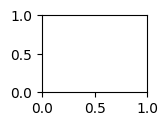

In [203]:
i=0
for j in range(0,len(core_motifs),2):
    
    fig = plt.figure(figsize = (3,1))
    plt.subplot(1,2,1)
    logo = seq_logo(core_motifs[j], height=100, nt_width=50, norm=0, alphabet='dna')
    plot_seq_logo(logo, nt_width=20, step_multiple=4)    
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(core_names[i], fontsize=14)

    plt.subplot(1,2,2)
    logo = seq_logo(core_motifs[j+1], height=100, nt_width=50, norm=0, alphabet='dna')
    plot_seq_logo(logo, nt_width=20, step_multiple=4)    
    plt.xticks([])
    plt.yticks([])

    
    i += 1

# Janggu resources

In [1]:
from pkg_resources import resource_filename

The reference genome is made up of a concatenation of Oct4 and Mafk binding sites and we shall use all regions on chromosome 'pseudo1' as training and 'pseudo2' as test chromosomes.

In [7]:
#
ref_file = resource_filename("eugene", "datasets/janggu_resources/pseudo_genome.fa")
roi_train_file = resource_filename("eugene", "datasets/janggu_resources/roi_train.bed")
roi_test_file = resource_filename("eugene", "datasets/janggu_resources/roi_test.bed")
peak_file = resource_filename("eugene", "datasets/janggu_resources/scores.bed")

In [8]:
import pybedtools

In [11]:
test_bedtool = pybedtools.BedTool(peak_file)

In [13]:
test_bedtool.head()

pseudo1	0	779400
 pseudo2	0	20000
 

In [14]:
import eugene as eu

In [51]:
dna, cov = eu.dl.read_bed(
    bed_file=peak_file,
    roi_file=roi_train_file,
    ref_file=ref_file,
    binsize=200,
    order=5,
    cache=True,
    return_janggu=True
)

environment variable JANGGU_OUTPUT not set. Will use JANGGU_OUTPUT=/Users/adamklie/janggu_results


In [120]:
#step_size

In [52]:
dna.shape, cov.shape

((7797, 196, 1, 1024), (7797, 1, 1, 1))

In [59]:
dna_model = SqueezeDim(ReduceDim(dna))
cov_model = SqueezeDim(ReduceDim(cov))

In [67]:
dna_model[:

(7797, 1024)

In [58]:
from sklearn.linear_model import LogisticRegression

In [68]:
model = LogisticRegression()
model.fit(dna_model, cov_model)

/Users/adamklie/miniconda3/envs/eugene/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
model

In [73]:
dna_test, cov_test = eu.dl.read_bed(
    bed_file=peak_file,
    roi_file=roi_test_file,
    ref_file=ref_file,
    binsize=200,
    order=5,
    return_janggu=True
)

In [74]:
dna_test_model = SqueezeDim(ReduceDim(dna_test))
cov_test_model = SqueezeDim(ReduceDim(cov_test))

In [75]:
dna_test_model.shape

(200, 1024)

In [76]:
logregpred = model.predict(dna_test_model)

In [77]:
from sklearn.metrics import roc_auc_score

In [79]:
roc_auc_score(cov_test_model[:], logregpred)

0.845

In [41]:
from eugene.external.janggu.data import SqueezeDim, ReduceDim

In [39]:
JangguSequence?

Init signature:
JangguSequence(
    inputs,
    outputs=None,
    sample_weights=None,
    batch_size=32,
    shuffle=False,
    as_dict=True,
)
Docstring:     
JangguSequence class.

This class is a subclass of keras.utils.Sequence.
It is used to serve the fit_generator, predict_generator
and evaluate_generator.
It can also be used with the new keras interface (>=2.4.3).

Parameters
---------
inputs : :class:`Dataset`, list(:class:`Dataset`) or array-like
    Dataset or list(Dataset).
outputs :  :class:`Dataset`, list(:class:`Dataset`), array-like or None
    Dataset or list(Dataset).
sample_weights : array-like or None
    Array or list of sample weights.
batch_size : int
    Batch size. Default: 32
shuffle : boolean
    Whether to shuffle the data. Default: False
as_dict : boolean
    Whether to return mini-batches as dict or unnamed tuples.
    In the latter case, the order of the input arguments
    reflects the order to the mini-batch tuples. Default: True
File:           ~/Deskt

In [121]:
ref_file = resource_filename("eugene", "datasets/janggu_resources/sample_genome.fa")
roi_file = resource_filename("eugene", "datasets/janggu_resources/sample.bed")
bam_file = resource_filename("eugene", "datasets/janggu_resources/sample2.bam")

In [124]:
sdata = eu.dl.read_bam(
    bam_file=bam_file,
    roi_file=roi_file,
    ref_file=ref_file,
    binsize=200,
    resolution=200,
    order=1,
)

In [125]:
sdata.seqs_annot.sum(axis=0).max()

0.0

In [93]:
from eugene.external.janggu.data import Cover

In [126]:
cover = Cover.create_from_bam('read_coverage',
                              bamfiles=bam_file,
                              binsize=200,
                              stepsize=200,
                              stranded=False,
                              roi=roi_file)

In [130]:
cover.shape

(100, 200, 1, 1)

In [85]:
sdata["target_0"].value_counts()

0.0    7797
Name: target_0, dtype: int64

In [137]:
ref_file = resource_filename("eugene", "datasets/janggu_resources/sample_genome.fa")
roi_file = resource_filename("eugene", "datasets/janggu_resources/sample.bed")
bw_file = resource_filename("eugene", "datasets/janggu_resources/sample.bw") 

In [172]:
# True labels may be obtained from a BED file
cover = Cover.create_from_bigwig('cov',
                                  bigwigfiles=bw_file,
                                  roi=roi_file,
                                  binsize=200,
                                  resolution=50)

In [149]:
# True labels may be obtained from a BED file
cover = Cover.create_from_bigwig('cov',
                                  bigwigfiles=bw_file,
                                  roi=roi_file,
                                  binsize=200,
                                  stepsize=200
) 

In [150]:
cover.shape

(100, 200, 1, 1)

In [151]:
cover[:].max()

2.0

In [158]:
sdata = eu.dl.read_bigwig(
    ref_file=ref_file,
    bigwig_file=bw_file,
    roi_file=roi_file,
    binsize=200,
    resolution=50
)

In [162]:
sdata.seqs_annot.max(axis=0)

target_0    2.0
target_1    2.0
target_2    1.0
target_3    2.0
dtype: float64

In [163]:
cover

Cover('cov')

In [165]:
from eugene.external.janggu.data import LineTrack
from eugene.external.janggu.data import plotGenomeTrack

In [166]:
LineTrack

eugene.external.janggu.data.visualization.LineTrack

In [170]:
sdata.seqs_annot

,target_0,target_1,target_2,target_3
chr1:15000-15200,0.0,0.0,0.0,0.0
chr1:15200-15400,0.0,0.0,0.0,0.0
chr1:15400-15600,0.0,0.0,0.0,0.0
chr1:15600-15800,0.0,0.0,0.0,0.0
chr1:15800-16000,0.0,0.0,1.0,1.0
...,...,...,...,...
chr2:24000-24200,0.0,0.0,0.0,0.0
chr2:24200-24400,1.0,0.0,0.0,0.0
chr2:24400-24600,0.0,0.0,0.0,1.0
chr2:24600-24800,0.0,0.0,0.0,0.0


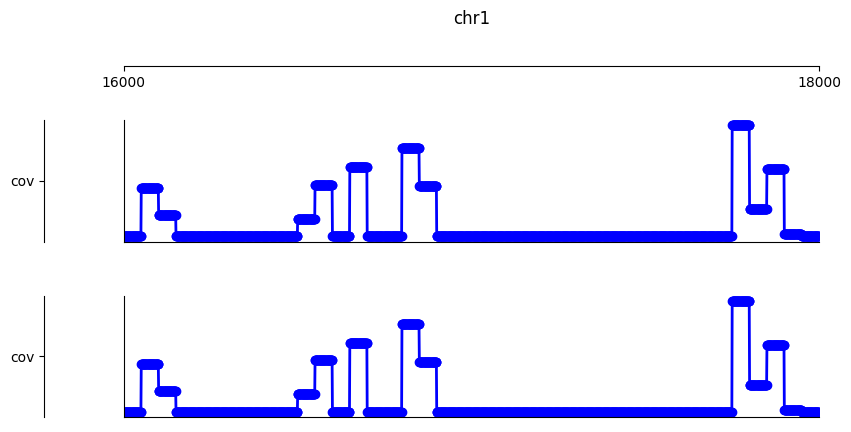

In [174]:
fig = plotGenomeTrack([LineTrack(cover), LineTrack(cover)], 'chr1', 16000, 18000)